# Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [74]:
import pandas as pd 
import matplotlib as plt
import numpy as np
import sklearn
import psycopg2 as psy
import csv
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
%matplotlib inline
from sklearn.decomposition import PCA 
import pandas as pd
from pandas.io import sql
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn import metrics


#### Step 2: Examine your data 

In [2]:
cancel = pd.read_csv("/Users/ajbentley/GA-DSI/projects/projects-weekly/project-07/\
assets/airport_cancellations.csv")

ops = pd.read_csv("/Users/ajbentley/GA-DSI/projects/projects-weekly/project-07/\
assets/Airport_operations.csv")

ap = pd.read_csv("/Users/ajbentley/GA-DSI/projects/projects-weekly/project-07/\
assets/airports.csv")

# ajbentley

# EKandTower


### Intro: Write a problem statement / aim for this project

Objective: Your task is to understand the distribution, characteristics, and components of individual airports operations that are leading to these delays.


First step is to identify which airports are the "problem children." We can do this with PCA and clustering.

Will run naive PCA and pare down on features to reduce overfitting until we can get at least 70% explained on 3 features. Then we'll use those features to cluster.

Clustering on PCAs should show what airports have higher than normal delay times and whose operations have been flat or worsening.

Once we ID what airports are the problems we can figure out what they have in common. 

Once they have been identified we can do classification to find out what the specific metrics are that are impacting their efficiancy. 

### Part 1: Create a PostgreSQL database 

#### 1. Let's create a database where we can house our airport data

In [3]:
# !conda install pyscopg2
# !pip install ipython-sql


In [4]:
%load_ext sql


In [5]:
# # from forzavitale repo

# engine = create_engine('postgresql://@localhost:5432/airportdb')

# cancel.to_sql('cancel', engine)
# operations.to_sql('ops', engine)
# airports.to_sql('ap', engine)

# %%sql 
# postgresql://@localhost:5432/airportdb

In [6]:
# cancel = pd.read_sql("cancel", engine)
# operations = pd.read_sql("ops", engine)
# airports = pd.read_sql("ap", engine)

In [7]:
cancel.rename(columns ={'Airport':'AP_NAME'}, inplace=True)

In [8]:
df = cancel.join(ap, rsuffix='ap')
df.pop('AP_NAMEap');

In [9]:
df = df.join(ops, rsuffix='ops')

#### 1.2 What are the risks and assumptions of our data? 

While there is considerable information presented there is a massive amount of information that feels like it most be colinear (several flavors of delays and arrivals, all of which probably correlate highly). It would be useful to see if there is a way to combine.

There's also data that are missing. It would be significant to see meteorological data, which I have to imagine the FAA collects, to show whether temperature and precipitation have seen significant shifts in this time.

It could be useful to see whether there is any difference in monthly numbers. Has tourism increased?

Once we get down to the individual airports that we need to consider it would be good to see whether there have been changes in the airlines serving the airport or in the sources / destinations of the planes. If flights from Denver tend to be late and they've just started a new direct flight from Denver to DC then the delays in DC would change.

There is a mixture of measurement scales--total counts, coordinates, percentages, and minutes. Data will definitely need standardization to be usable.



### Part 2: Exploratory Data Analysis

#### 2.1 Plot and Describe the Data

In [10]:
df.describe()

Year  Departure Cancellations  Arrival Cancellations  \
count   805.000000               805.000000             805.000000   
mean   2008.986335              1292.038509            1333.124224   
std       3.158116              1835.961943            1975.224868   
min    2004.000000                 0.000000               0.000000   
25%    2006.000000               349.000000             314.000000   
50%    2009.000000               663.000000             642.000000   
75%    2012.000000              1472.000000            1523.000000   
max    2014.000000             16618.000000           17571.000000   

       Departure Diversions  Arrival Diversions          Key    Latitude  \
count            805.000000          805.000000   805.000000  805.000000   
mean             173.315528          169.413665  2488.650932   30.522748   
std              172.345539          228.521615  1607.433809    2.806227   
min                0.000000            0.000000   254.000000   17.701556   
25%               62.000000           41.000000   880.000000   29.607333   
50%              110.000000           84.000000  2900.000000   31.179278   
75%              236.000000          190.000000  3319.000000   32.493417   
max             1064.000000         1948.000000  5251.000000   33.303458   

        Longitude         year  departures for metric computation  \
count  805.000000   805.000000                         805.000000   
mean   -93.577507  2009.014907                      111331.108075   
std     12.880292     3.152394                       99041.431112   
min   -177.381308  2004.000000                         261.000000   
25%    -97.969472  2006.000000                       39279.000000   
50%    -93.745023  2009.000000                       73741.000000   
75%    -84.557425  2012.000000                      166455.000000   
max    -64.801722  2014.000000                      491826.000000   

                  ...              percent on-time airport departures  \
count             ...                                      805.000000   
mean              ...                                        0.719039   
std               ...                                        0.088554   
min               ...                                        0.245700   
25%               ...                                        0.686300   
50%               ...                                        0.736200   
75%               ...                                        0.770700   
max               ...                                        0.897400   

       percent on-time gate arrivals  average_gate_departure_delay  \
count                     805.000000                    805.000000   
mean                        0.760144                     13.299888   
std                         0.068339                      4.076106   
min                         0.349500                      5.350000   
25%                         0.738100                     10.950000   
50%                         0.769300                     12.670000   
75%                         0.797500                     14.820000   
max                         0.880300                     40.800000   

       average_taxi_out_time  average taxi out delay  \
count             805.000000              805.000000   
mean               13.813453                3.604907   
std                 3.836060                2.397139   
min                 7.040000                0.000000   
25%                11.330000                2.230000   
50%                12.930000                3.030000   
75%                15.720000                4.190000   
max                35.760000               18.940000   

       average airport departure delay  average airborne delay  \
count                       805.000000              805.000000   
mean                         16.059615                2.930112   
std                           4.937230                1.199621   
min               

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805 entries, 0 to 804
Data columns (total 33 columns):
AP_NAME                               805 non-null object
Year                                  805 non-null float64
Departure Cancellations               805 non-null float64
Arrival Cancellations                 805 non-null float64
Departure Diversions                  805 non-null float64
Arrival Diversions                    805 non-null float64
Key                                   805 non-null float64
LocID                                 804 non-null object
ALIAS                                 631 non-null object
Facility Type                         805 non-null object
FAA REGION                            805 non-null object
COUNTY                                805 non-null object
CITY                                  805 non-null object
STATE                                 805 non-null object
AP Type                               805 non-null object
Latitude           

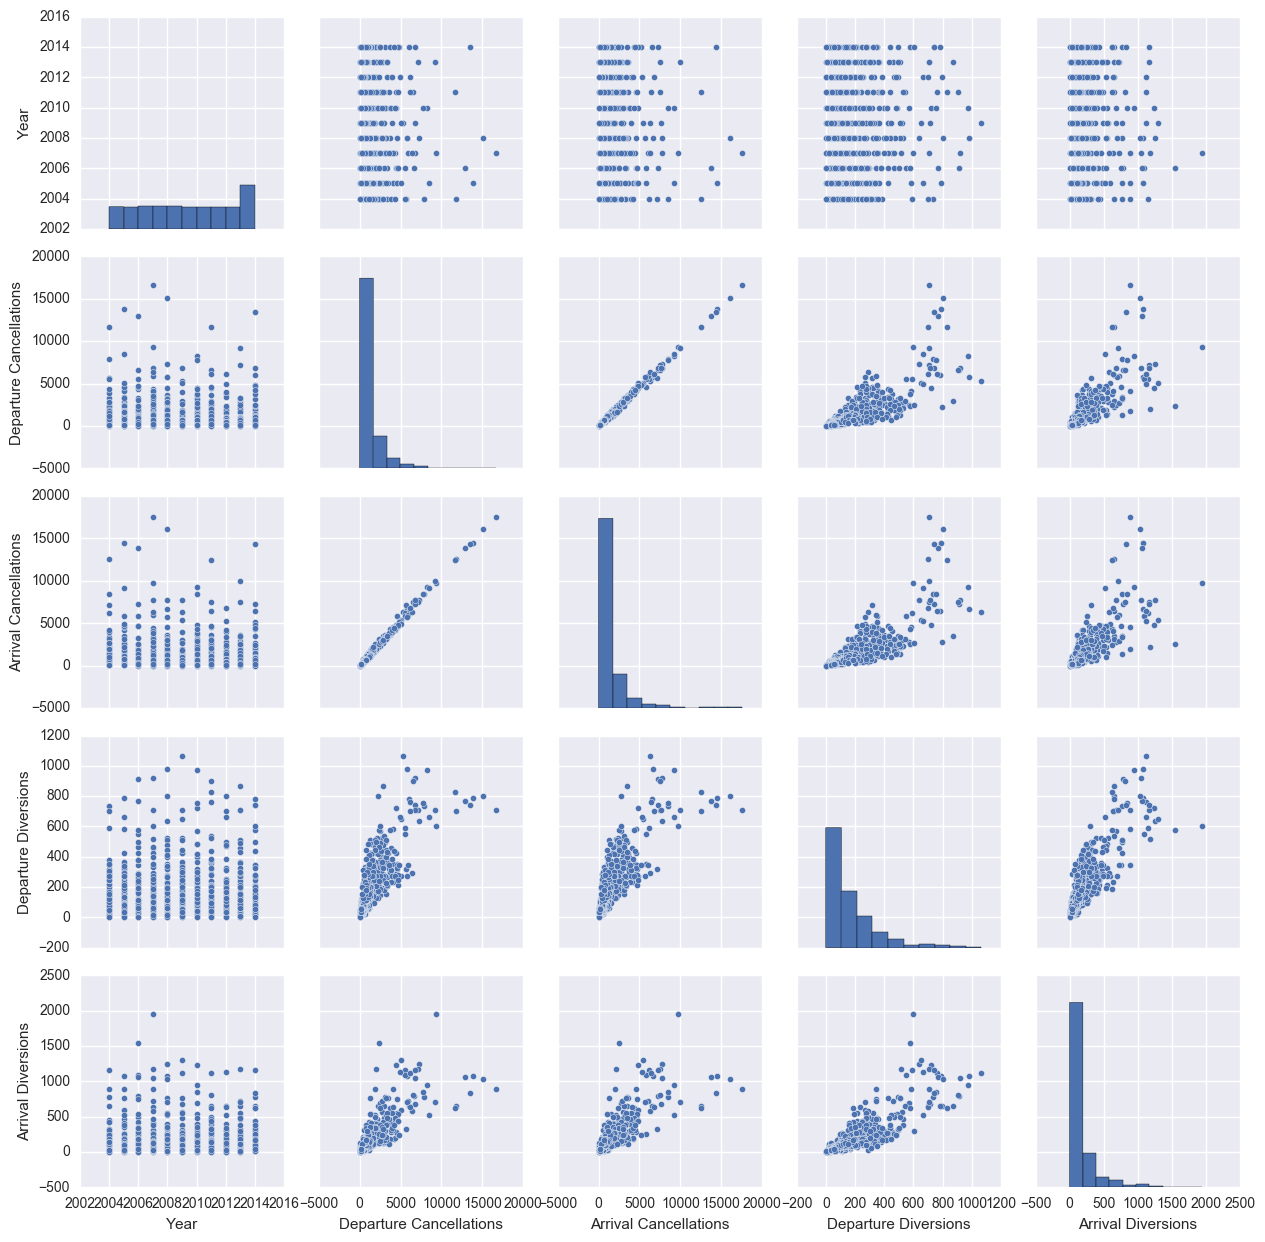

In [12]:
sns.pairplot(cancel, kind="scatter")

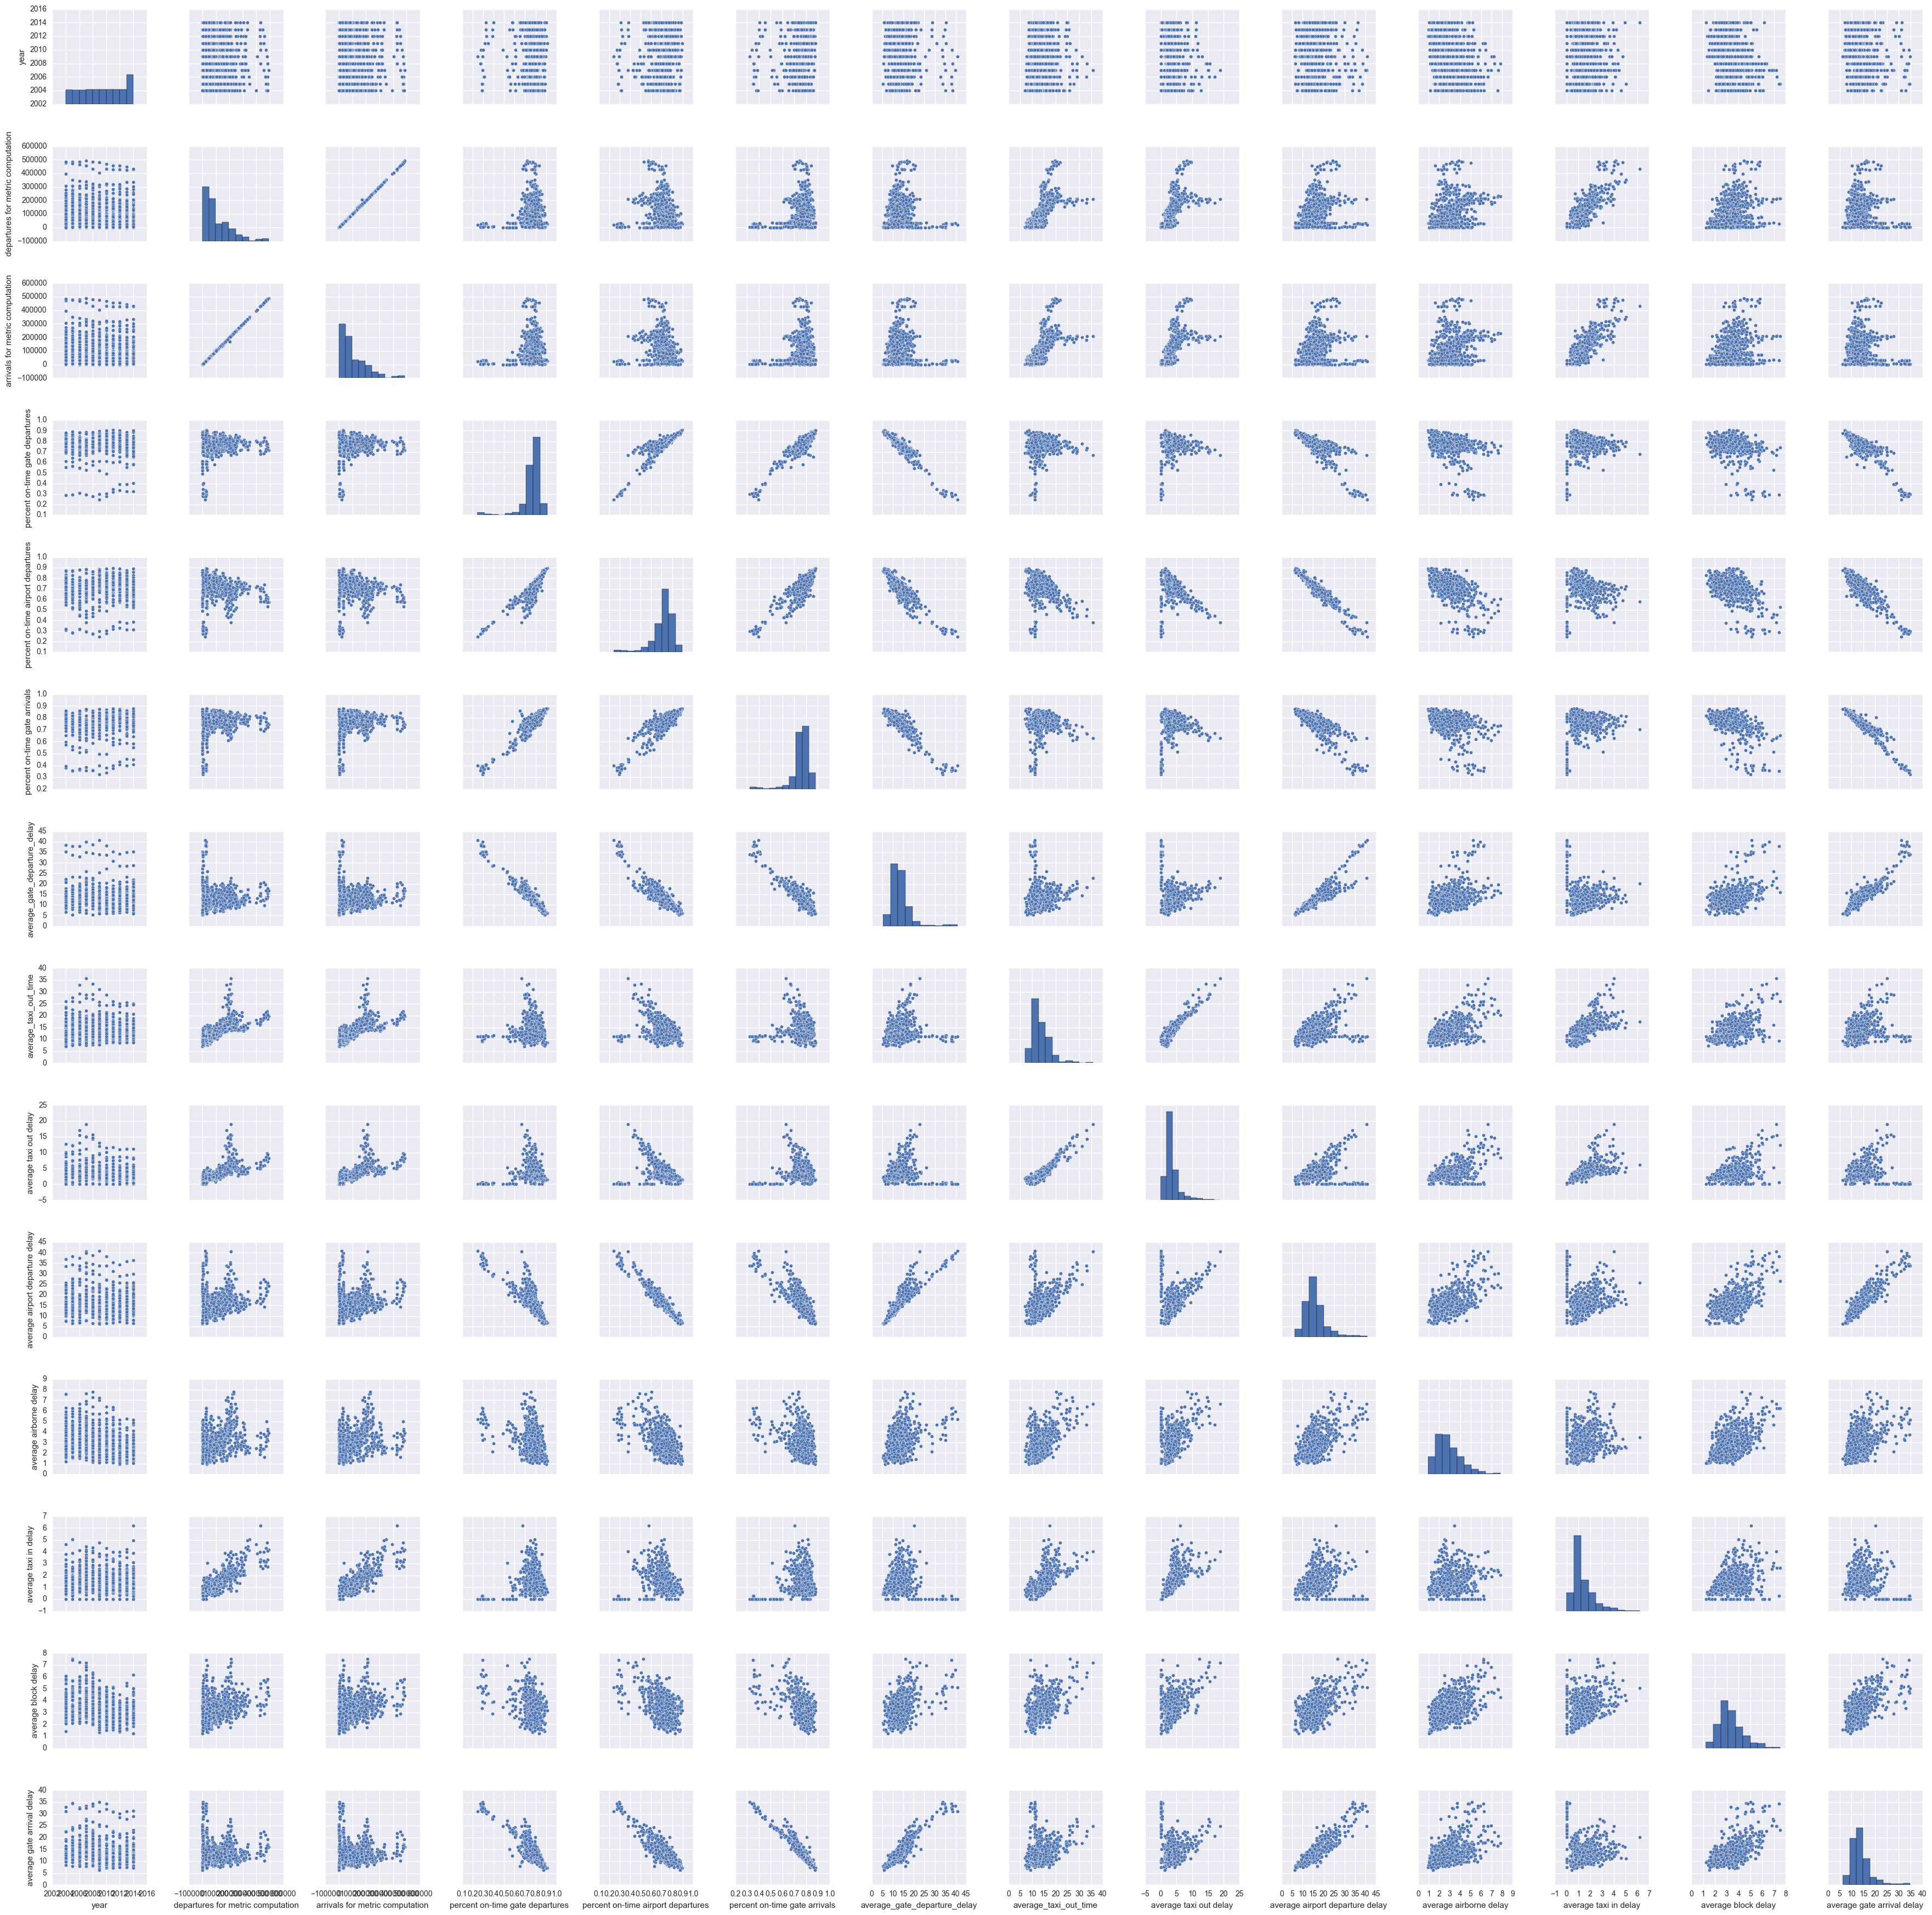

In [13]:
sns.pairplot(ops, kind="scatter")

In [14]:

# df['AP_NAME'] = LabelEncoder().fit_transform(df['AP_NAME'])
df['FAA REGION'] = LabelEncoder().fit_transform(df['FAA REGION'])
df['LocID'] = LabelEncoder().fit_transform(df['LocID'])

df['ALIAS'] = LabelEncoder().fit_transform(df['ALIAS'])
df['Facility Type'] = LabelEncoder().fit_transform(df['Facility Type'])
df['COUNTY'] = LabelEncoder().fit_transform(df['COUNTY'])
df['CITY'] = LabelEncoder().fit_transform(df['CITY'])
df['STATE'] = LabelEncoder().fit_transform(df['STATE'])
df['AP Type'] = LabelEncoder().fit_transform(df['AP Type'])
df['Boundary Data Available'] = LabelEncoder().fit_transform(df['Boundary Data Available'])
df['airport'] = LabelEncoder().fit_transform(df['airport'])




/Users/ajbentley/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


In [132]:
df.head(10)

AP_NAME    Year  Departure Cancellations  Arrival Cancellations  \
0     ABQ  2004.0                    242.0                  235.0   
1     ABQ  2005.0                    221.0                  190.0   
2     ABQ  2006.0                    392.0                  329.0   
3     ABQ  2007.0                    366.0                  304.0   
4     ABQ  2008.0                    333.0                  300.0   
5     ABQ  2009.0                    192.0                  162.0   
6     ABQ  2010.0                    222.0                  177.0   
7     ABQ  2011.0                    345.0                  294.0   
8     ABQ  2012.0                    237.0                  181.0   
9     ABQ  2013.0                    232.0                  212.0   

   Departure Diversions  Arrival Diversions     Key  LocID  ALIAS  \
0                  71.0                46.0  3443.0    687    280   
1                  61.0                33.0  5088.0    799      0   
2                  71.0               124.0  2886.0    635     13   
3                 107.0                45.0  2879.0    769      8   
4                  79.0                42.0  2883.0    798     15   
5                  74.0                26.0  2884.0    655     12   
6                  71.0                50.0  2881.0    556     10   
7                  77.0                61.0  5087.0    800      0   
8                  65.0                60.0  5086.0    325      0   
9                  62.0                46.0  3442.0    686    160   

   Facility Type             ...              \
0              0             ...               
1              0             ...               
2              0             ...               
3              0             ...               
4              0             ...               
5              0             ...               
6              0             ...               
7              0             ...               
8              0             ...               
9              0             ...               

   percent on-time airport departures  percent on-time gate arrivals  \
0                              0.7809                         0.7921   
1                              0.7922                         0.8001   
2                              0.7756                         0.7746   
3                              0.7704                         0.7647   
4                              0.7844                         0.7875   
5                              0.8147                         0.8224   
6                              0.7907                         0.8047   
7                              0.7758                         0.8022   
8                              0.7940                         0.8177   
9                              0.7402                         0.7554   

   average_gate_departure_delay  average_taxi_out_time  \
0                         10.38                   9.89   
1                          9.60                   9.79   
2                         10.84                   9.89   
3                         11.29                  10.34   
4                         10.79                  10.41   
5                          9.24                   9.88   
6                         10.25                   9.95   
7                         10.81                  10.50   
8                         10.55                  10.27   
9                         12.56                  10.77   

   average taxi out delay  average airport departure delay  \
0                    2.43                            12.10   
1                    2.29                            11.20   
2                    2.16                            12.33   
3                    2.40                            12.95   
4                    2.41                            12.32   
5                    1.89                            10.45   
6                    2.05                            11.58   
7                    2.51

In [ ]:
Adding change columns for 

df['Chg'] = df['Value'].pct_change()

In [15]:
# making new db with only 2014 data. As indicated at the head of this document, my preferred analysis on this would\
# to just use 2014 and the change metrics. I think prior years' data are useful mostly for the change.

df14 = pd.DataFrame(df.loc[df['Year'] == 2014])
df14.head()

AP_NAME    Year  Departure Cancellations  Arrival Cancellations  \
10     ABQ  2014.0                    315.0                  274.0   
21     ANC  2014.0                    111.0                  162.0   
32     ATL  2014.0                   5977.0                 6483.0   
43     AUS  2014.0                    484.0                  435.0   
54     BDL  2014.0                    467.0                  421.0   

    Departure Diversions  Arrival Diversions     Key  LocID  ALIAS  \
10                  66.0                37.0  2885.0    677     11   
21                  74.0                28.0   982.0    570    421   
32                 781.0               655.0  4196.0    788      0   
43                  88.0                97.0  3282.0    628    482   
54                  57.0                32.0  5145.0    693      0   

    Facility Type             ...              \
10              0             ...               
21              0             ...               
32              0             ...               
43              0             ...               
54              0             ...               

    percent on-time airport departures  percent on-time gate arrivals  \
10                              0.7148                         0.7320   
21                              0.8074                         0.8600   
32                              0.7134                         0.8123   
43                              0.7382                         0.7222   
54                              0.7605                         0.7569   

    average_gate_departure_delay  average_taxi_out_time  \
10                         14.30                  10.64   
21                         11.33                  11.33   
32                         11.99                  17.40   
43                         14.16                  11.76   
54                         12.64                  12.76   

    average taxi out delay  average airport departure delay  \
10                    2.41                            15.99   
21                    1.33                            12.34   
32                    4.92                            15.93   
43                    2.06                            15.59   
54                    2.58                            14.39   

    average airborne delay  average taxi in delay  average block delay  \
10                    1.73                   1.02                 2.40   
21                    4.09                   0.54                 4.57   
32                    2.74                   2.77                 3.21   
43                    2.25                   1.08                 2.88   
54                    2.34                   0.95                 2.64   

    average gate arrival delay  
10                       14.72  
21                       10.82  
32                       12.42  
43                       16.20  
54                       14.79  

[5 rows x 33 columns]

In [16]:
# create df that only references delay and arrival information


dfn = ['AP_NAME','Departure Cancellations','Arrival Cancellations','Departure Diversions','Arrival Diversions',\
       'departures for metric computation','arrivals for metric computation',\
       'percent on-time gate departures', 'percent on-time airport departures','percent on-time gate arrivals',\
       'average_taxi_out_time','average taxi out delay','average airport departure delay','average airborne delay',\
       'average taxi in delay','average block delay','average gate arrival delay' ]
dfn = pd.DataFrame(df14[dfn])
dfn.head()


AP_NAME  Departure Cancellations  Arrival Cancellations  \
10     ABQ                    315.0                  274.0   
21     ANC                    111.0                  162.0   
32     ATL                   5977.0                 6483.0   
43     AUS                    484.0                  435.0   
54     BDL                    467.0                  421.0   

    Departure Diversions  Arrival Diversions  \
10                  66.0                37.0   
21                  74.0                28.0   
32                 781.0               655.0   
43                  88.0                97.0   
54                  57.0                32.0   

    departures for metric computation  arrivals for metric computation  \
10                              33292                            33137   
21                              71099                            66704   
32                             428954                           428312   
43                              60588                            60264   
54                              39279                            39109   

    percent on-time gate departures  percent on-time airport departures  \
10                           0.7451                              0.7148   
21                           0.8288                              0.8074   
32                           0.7899                              0.7134   
43                           0.7627                              0.7382   
54                           0.7953                              0.7605   

    percent on-time gate arrivals  average_taxi_out_time  \
10                         0.7320                  10.64   
21                         0.8600                  11.33   
32                         0.8123                  17.40   
43                         0.7222                  11.76   
54                         0.7569                  12.76   

    average taxi out delay  average airport departure delay  \
10                    2.41                            15.99   
21                    1.33                            12.34   
32                    4.92                            15.93   
43                    2.06                            15.59   
54                    2.58                            14.39   

    average airborne delay  average taxi in delay  average block delay  \
10                    1.73                   1.02                 2.40   
21                    4.09                   0.54                 4.57   
32                    2.74                   2.77                 3.21   
43                    2.25                   1.08                 2.88   
54                    2.34                   0.95                 2.64   

    average gate arrival delay  
10                       14.72  
21                       10.82  
32                       12.42  
43                       16.20  
54                       14.79

In [17]:
# sns.pairplot(dfn, kind="scatter")

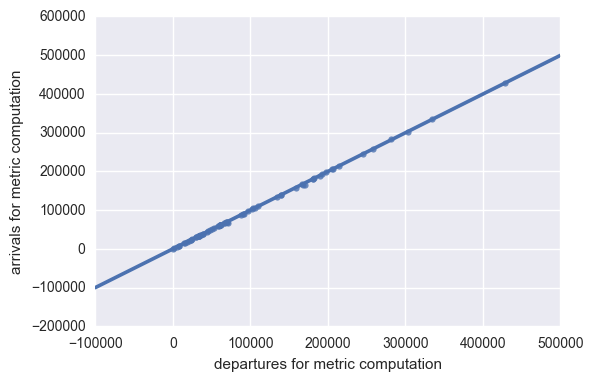

In [18]:
ax = sns.regplot(x="departures for metric computation", y="arrivals for metric computation", data=df14)


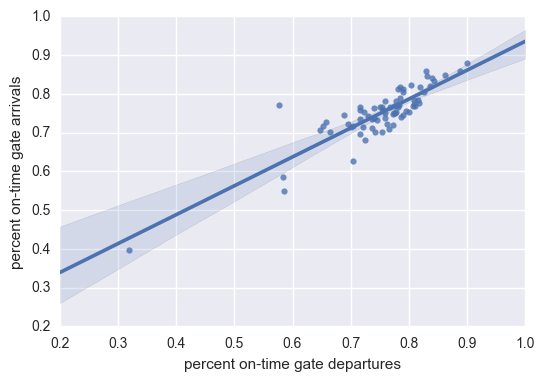

In [19]:
ax = sns.regplot(x="percent on-time gate departures", y="percent on-time gate arrivals", data=df14)


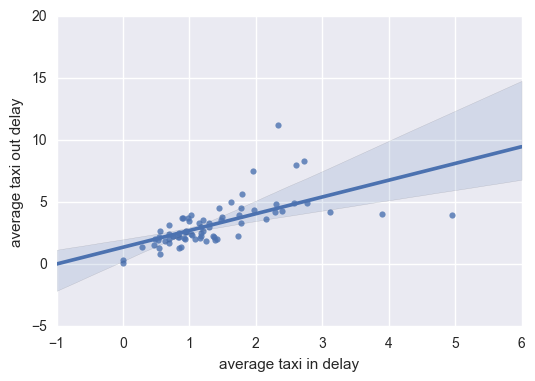

In [20]:
ax = sns.regplot(x="average taxi in delay", y="average taxi out delay", data=df14)


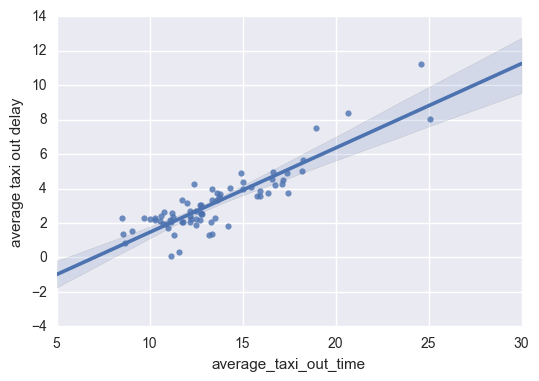

In [21]:
ax = sns.regplot(x="average_taxi_out_time", y="average taxi out delay", data=df14)


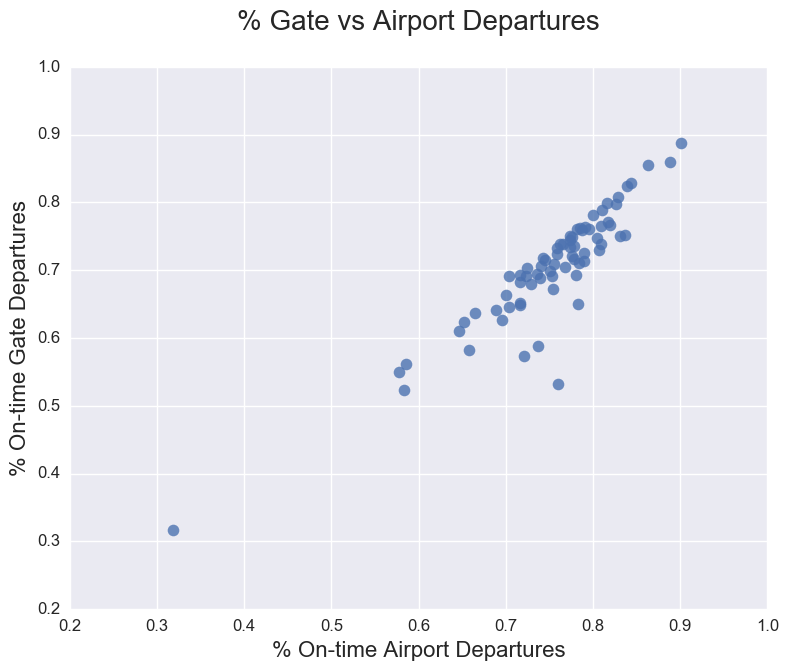

In [22]:
fig = plt.figure(figsize=(9,7))
ax = fig.gca()

ax = sns.regplot('percent on-time gate departures', 'percent on-time airport departures', data=df14, fit_reg=False, scatter_kws={'s':70}, ax=ax)
ax.set_ylabel('% On-time Gate Departures', fontsize=16)
ax.set_xlabel('% On-time Airport Departures', fontsize=16)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
ax.set_title('% Gate vs Airport Departures\n', fontsize=20)

plt.show()

#### Are there any unique values? 

They're almost all unique values. 

### Part 3: Data Mining

#### 3.1 Create Dummy Variables

#### 4.1 Confirm that the dataset has a normal distribution. How can you tell? 

In [23]:
dfn.describe()

Departure Cancellations  Arrival Cancellations  Departure Diversions  \
count                72.000000              72.000000             72.000000   
mean               1372.652778            1413.902778            171.111111   
std                1997.878573            2149.679014            178.508733   
min                  17.000000              11.000000              3.000000   
25%                 428.000000             388.250000             56.500000   
50%                 633.000000             643.000000             88.000000   
75%                1365.250000            1489.250000            211.500000   
max               13454.000000           14355.000000            781.000000   

       Arrival Diversions  departures for metric computation  \
count           72.000000                          72.000000   
mean           163.458333                       99313.375000   
std            217.219493                       88534.604766   
min              7.000000                         729.000000   
25%             34.750000                       34276.250000   
50%             82.500000                       64522.000000   
75%            176.500000                      161125.250000   
max           1164.000000                      428954.000000   

       arrivals for metric computation  percent on-time gate departures  \
count                        72.000000                        72.000000   
mean                      98989.277778                         0.752960   
std                       88426.863627                         0.081974   
min                         752.000000                         0.318500   
25%                       33970.750000                         0.722600   
50%                       64461.000000                         0.767050   
75%                      159243.750000                         0.796575   
max                      428312.000000                         0.900700   

       percent on-time airport departures  percent on-time gate arrivals  \
count                           72.000000                      72.000000   
mean                             0.704911                       0.751256   
std                              0.088062                       0.070395   
min                              0.317000                       0.398200   
25%                              0.670500                       0.722800   
50%                              0.716000                       0.755100   
75%                              0.753750                       0.782650   
max                              0.888100                       0.878400   

       average_taxi_out_time  average taxi out delay  \
count              72.000000               72.000000   
mean               13.524861                3.183472   
std                 3.256936                1.814836   
min                 8.520000                0.110000   
25%                11.245000                2.102500   
50%                12.765000                2.615000   
75%                15.117500                3.962500   
max                25.100000               11.210000   

       average airport departure delay  average airborne delay  \
count                        72.000000               72.000000   
mean                         16.863333                2.660000   
std                           4.616593                0.981281   
min                           6.440000                1.260000   
25%                          14.295000                1.967500   
50%                          16.475000                2.440000   
75%                          19.157500                3.130000   
max                          35.400000                6.410000   

       average taxi in delay  average block delay  average gate arrival delay  
count              72.000000            72.000000                   72.000000  
mean                1.335833             3.200694                   14.472778  
std              

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1347b8590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x138516110>]], dtype=object)

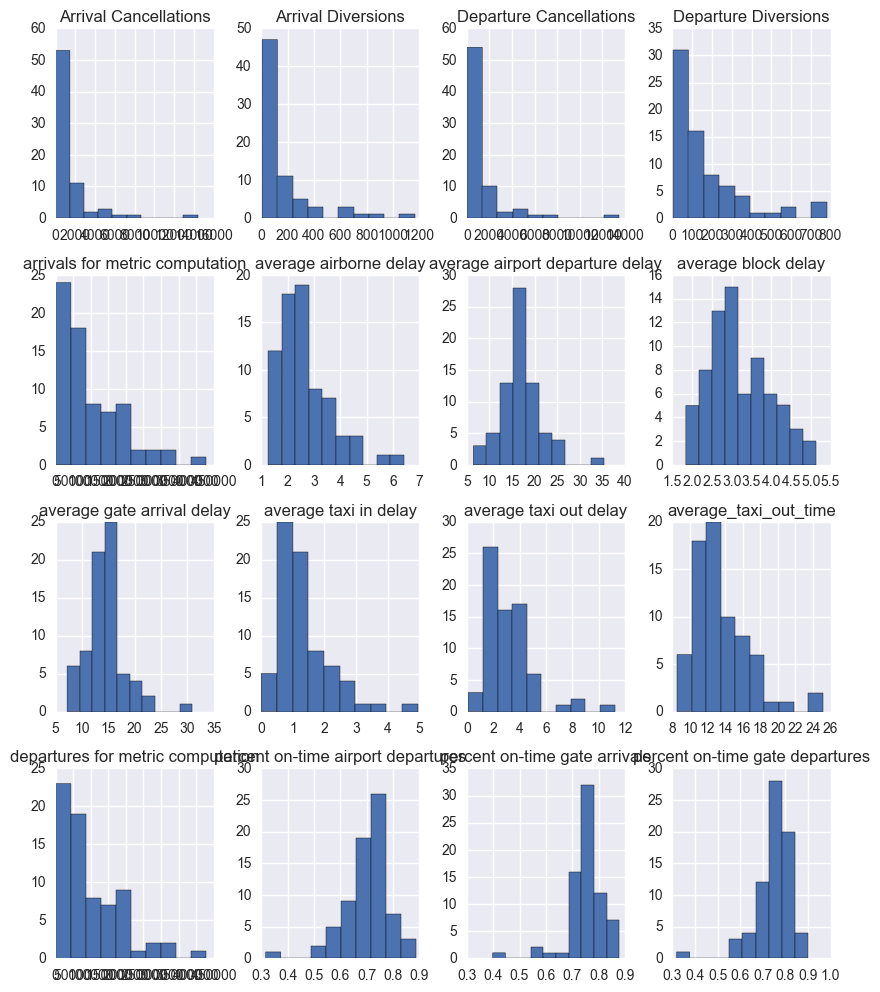

In [24]:
dfn.hist(figsize=(10,12))

In [25]:
# xStand = StandardScaler().fit_transform(dfn)

In [26]:
# dfs = pd.DataFrame(xStand)
# dfs.head()

In [27]:
# dfs.hist(figsize=(10,12))

### Part 4: Define the Data

#### 4.2 Find correlations in the data

In [135]:


df_corr = abs(dfn.corr())
# df_corrdf = pd.DataFrame(df_corr)
# df_corrdf

df_corr = df_corr.applymap(lambda x: x if x >= 0.9 else '')
df_corr

Year Departure Cancellations  \
Year                                                              
Departure Cancellations                                       1   
Arrival Cancellations                                  0.998869   
Departure Diversions                                              
Arrival Diversions                                                
Key                                                               
LocID                                                             
ALIAS                                                             
Facility Type                                                     
FAA REGION                                                        
COUNTY                                                            
CITY                                                              
STATE                                                             
AP Type                                                           
Latitude                                                          
Longitude                                                         
Boundary Data Available                                           
airport                                                           
year                                                              
departures for metric computation                                 
arrivals for metric computation                                   
percent on-time gate departures                                   
percent on-time airport departures                                
percent on-time gate arrivals                                     
average_gate_departure_delay                                      
average_taxi_out_time                                             
average taxi out delay                                            
average airport departure delay                                   
average airborne delay                                            
average taxi in delay                                             
average block delay                                               
average gate arrival delay                                        

                                   Arrival Cancellations Departure Diversions  \
Year                                                                            
Departure Cancellations                         0.998869                        
Arrival Cancellations                                  1                        
Departure Diversions                                                        1   
Arrival Diversions                                                              
Key                                                                             
LocID                                                                           
ALIAS                                                                           
Facility Type                                                                   
FAA REGION                                                                      
COUNTY                                                                          
CITY                                                                            
STATE                                                                           
AP Type                                                                         
Latitude                                                                        
Longitude                                                                       
Boundary Data Available                                                         
airport                                                                         
year                                                                            
departures for metric computation                                               
arrivals for metric computation                                                 
percent on-time gate departures          

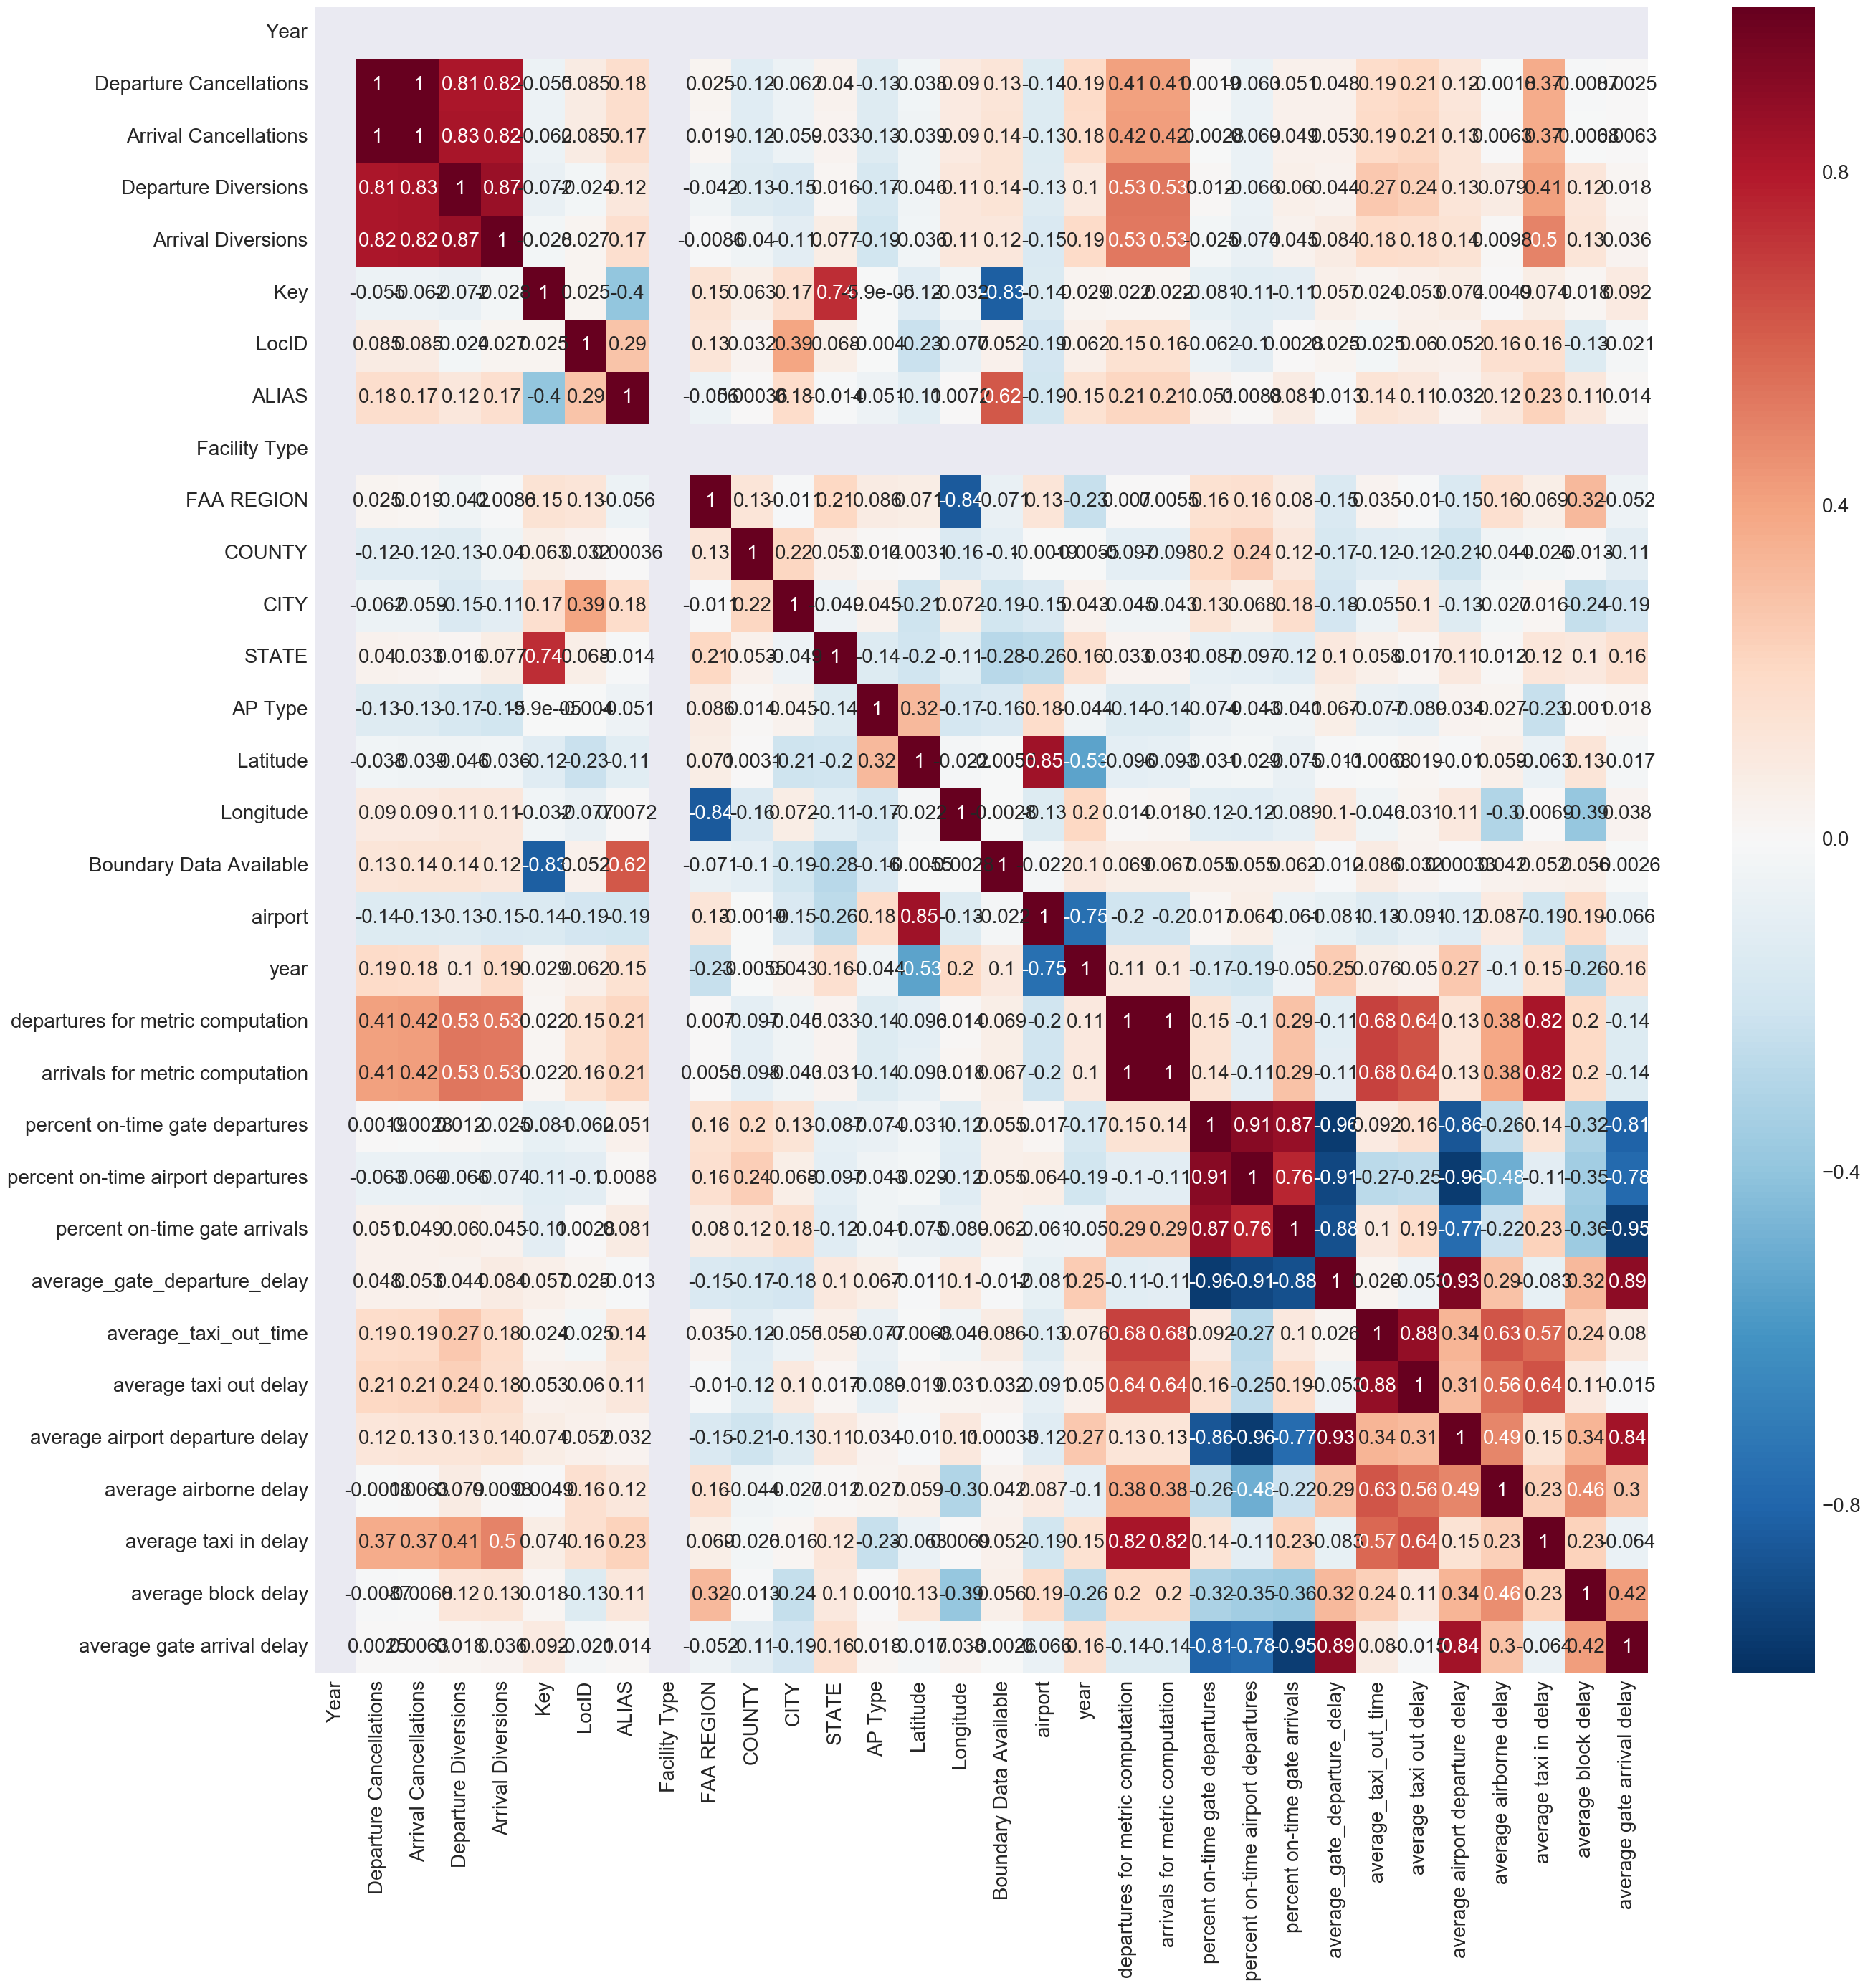

In [136]:

dfn_corr = dfn.corr()
dfncr = pd.DataFrame(dfn_corr)


fig, ax = plt.subplots(figsize=(30,30))   
sns.set(font_scale=2)
ax = sns.heatmap(dfncr, annot=True, annot_kws={"size": 20})


In [30]:
# running again on standardized data and exporting to csv so that I can play with it in Excel
df_corr = dfn.corr()
df_corrdf = pd.DataFrame(df_corr)
df_corrdf
df_corrdf.to_csv('/Users/ajbentley/GA-DSI/projects/projects-weekly/project-07/\
assets/df_corrdf.csv')

#### 4.3 What is the value of understanding correlations before PCA? 

Answer: to get insight into the amount of colinearity between features  and allow you to decide whether you should eliminate any. 

Checking for pairs with correlations >.95. Will exclude the one of the pair with the greater sum of absolute correlations for all features (the one that has more of its explanatory power already covered by other features). If there is a tie (or close to) I'll favor delays over arrivals.

A - Departure Cancellations and Arrival Cancellations .999 correlated, dropping Arrival Cancellations

B - Deparetures for Metric Computations and Arrivals for Metric Computations .999 correlated, dropping Arrivals

C - Average Airport Departure Delay and Percent on-time airport departures -.96 correlated, dropping Average Airport Departure Delay

D - Average Gate Arrival Delay and Percent on-time gate arrivals -.95 correlated, dropping Percent on-time Gate Arrivals.

_________

Had first done this naive--none of the above exclusions.

After doing this my cumed eigenvalues declined. Testing to see whether I should have done different exclusions if any.

0. Naive
i. ABCD excluded
ii. ABC excluded
iii. ABD excluded
iv. ACD excluded
v. BCD excluded
vi. inverse ABCD (excluded the other partner in the pair)
vii. iABC excluded
viii. iABD excluded
ix. iACD excluded
x. iBCD excluded

Data: Cum PC1 / PC2 / PC3
0.    36 / 66 / 82
i.    37 / 62 / 79
ii.   34 / 64 / 80
iii.  37 / 64 / 80
iv.   40 / 64 / 80
v.    38 / 62 / 80
vi.   37 / 62 / 80
vii.  35 / 64 / 81
viii. 36 / 65 / 81
ix.   41 / 64 / 80
x.    38 / 62 / 81


From this analysis I can see that dropping factors based on correlation is actually harmful and that I had been targeting the wrong member of the correlated pairs.

As a last test I'll look at dropping only one of the inverse members at a time:

dropping iA: 36 / 67 / 81
dropping iB: 35 / 65 / 82
dropping iC: 38 / 64 / 81
dropping iD: 38 / 65 / 81

So it looks like excluding for correlation is the wrong way to go.

In [31]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 10 to 804
Data columns (total 17 columns):
AP_NAME                               72 non-null object
Departure Cancellations               72 non-null float64
Arrival Cancellations                 72 non-null float64
Departure Diversions                  72 non-null float64
Arrival Diversions                    72 non-null float64
departures for metric computation     72 non-null int64
arrivals for metric computation       72 non-null int64
percent on-time gate departures       72 non-null float64
percent on-time airport departures    72 non-null float64
percent on-time gate arrivals         72 non-null float64
average_taxi_out_time                 72 non-null float64
average taxi out delay                72 non-null float64
average airport departure delay       72 non-null float64
average airborne delay                72 non-null float64
average taxi in delay                 72 non-null float64
average block delay           

In [32]:
dfn2 = pd.DataFrame(dfn)
# dfn2.drop(['Arrival Cancellations','arrivals for metric computation',\
#           'average airport departure delay','percent on-time gate arrivals'], axis=1,\
# inplace=True)
dfn2.drop(['average gate arrival delay'], axis=1,\
inplace=True)
dfn2.head();



#### 4.5 How can you improve your overall analysis? 

Answer: by dropping those colinear features.

### Part 5: Perform a PCA

#### 5.1 Conduct the PCA

In [33]:
x = dfn.ix[:,1:].values
y = dfn.ix[:,0].values

xStand = StandardScaler().fit_transform(x)
covMat = np.cov(xStand.T)

eigenValues, eigenVectors = np.linalg.eig(covMat)

In [34]:
# print(eigenValues)
# print(eigenVectors)

In [35]:
eigenPairs = [(np.abs(eigenValues[i]), eigenVectors[:,i]) for i in range(len(eigenValues))]
eigenPairs.sort()
eigenPairs.reverse()
for i in eigenPairs:
    print(i[0]);

5.8601459467
4.78491728564
2.60911415606
0.914026658765
0.716684999581
0.41797966957
0.284092673607
0.216259994579
0.187635271223
0.107863368956
0.0733230308307
0.0427888991724
0.00736418366528
0.00239744166913
0.000715226194679
4.33064632938e-05


In [36]:
totalEigen = sum(eigenValues)
varExpl = [(i / totalEigen)*100 for i in sorted(eigenValues, reverse=True)]
cumulvarExpl = np.cumsum(varExpl)

print(cumulvarExpl)

[  36.11721894   65.60759457   81.68807245   87.32139647   91.73846548
   94.31455546   96.06547384   97.39832624   98.5547589    99.21954182
   99.67144592   99.93516222   99.98054912   99.99532502   99.99973309
  100.        ]


In [37]:
airports_pca2 = PCA(n_components=2)

X2 = airports_pca2.fit_transform(xStand)

# airports_pca2.components_
# components_.X
# plot(X2)

In [38]:
PCAdf2 = pd.DataFrame(X2, columns=['PC1','PC2'])
PCAdf2.head()

PC1       PC2
0 -2.077225  0.238312
1 -1.735436 -1.225661
2  6.702670 -3.292956
3 -1.462501  0.288753
4 -1.837540 -0.377451

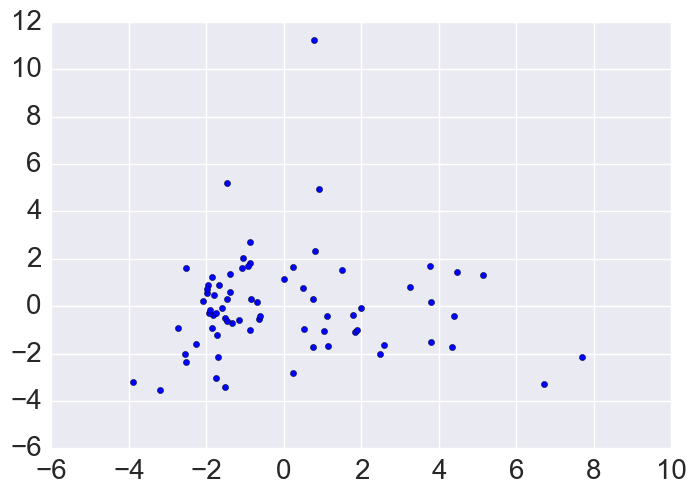

In [39]:
j = PCAdf2.PC1
k = PCAdf2.PC2

plt.scatter(j,k)

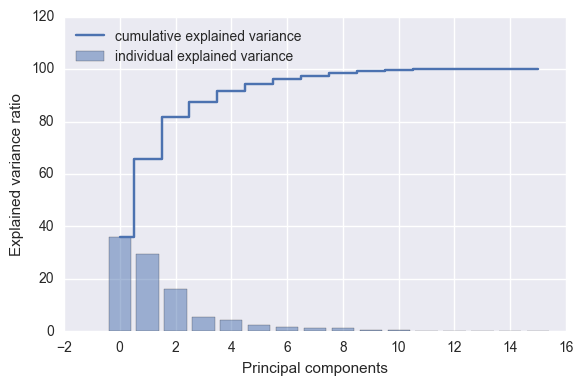

In [40]:
from matplotlib import pyplot as plt
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    sns.set(font_scale=1)
    plt.bar(range(len(cumulvarExpl)), varExpl, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(cumulvarExpl)), cumulvarExpl, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [41]:
eigen_pairs = [[eigenValues[i], eigenVectors[:,i]] for i in range(len(eigenValues))]
eigen_pairs.sort(reverse=True)

In [42]:
weight_2d_projection = np.hstack((eigen_pairs[0][1].reshape(eigenVectors.shape[1],1),
                                  eigen_pairs[1][1].reshape(eigenVectors.shape[1],1)))

print 'Weight data 2d PCA projection matrix:\n', weight_2d_projection;

Weight data 2d PCA projection matrix:
[[ 0.27733264  0.10576524]
 [ 0.27987117  0.10418357]
 [ 0.30137455  0.10345784]
 [ 0.29637337  0.09779977]
 [ 0.35105469  0.1417983 ]
 [ 0.35116857  0.14105239]
 [-0.06141643  0.42107114]
 [-0.17121183  0.39377781]
 [-0.01927337  0.43070271]
 [ 0.30014703  0.01376585]
 [ 0.28888706  0.04715274]
 [ 0.19593006 -0.38580784]
 [ 0.21175612 -0.16345828]
 [ 0.31928188  0.11918003]
 [ 0.14141327 -0.18579191]
 [ 0.08583358 -0.41607723]]


In [43]:
Z2 = x.dot(weight_2d_projection)

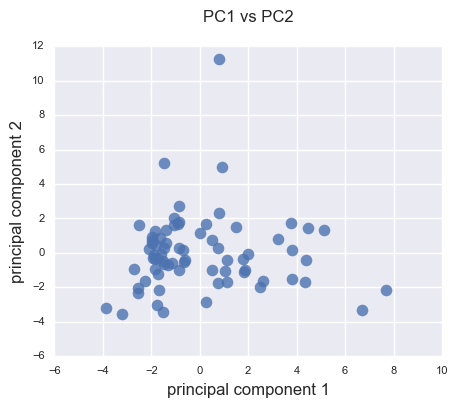

In [123]:
fig = plt.figure(figsize=(5,4))

ax = fig.gca()
ax = sns.regplot(j,k,
                 fit_reg=False, scatter_kws={'s':70}, ax=ax)

ax.set_xlabel('principal component 1', fontsize=12)
ax.set_ylabel('principal component 2', fontsize=12)


for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(8) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(8) 
    
ax.set_title('PC1 vs PC2\n', fontsize=12
            )

plt.show()

In [45]:
airports_pca3 = PCA(n_components=3)

X3 = airports_pca3.fit_transform(xStand)

In [49]:
# peida
# pc3 = pca3.fit_transform(df_cluster)

In [50]:

# peida
print airports_pca3.explained_variance_
print
print airports_pca3.explained_variance_ratio_

airports_pca3.components_

[ 5.77875503  4.7184601   2.57287646]

[ 0.36117219  0.29490376  0.16080478]


array([[ 0.27733264,  0.27987117,  0.30137455,  0.29637337,  0.35105469,
         0.35116857, -0.06141643, -0.17121183, -0.01927337,  0.30014703,
         0.28888706,  0.19593006,  0.21175612,  0.31928188,  0.14141327,
         0.08583358],
       [-0.10576524, -0.10418357, -0.10345784, -0.09779977, -0.1417983 ,
        -0.14105239, -0.42107114, -0.39377781, -0.43070271, -0.01376585,
        -0.04715274,  0.38580784,  0.16345828, -0.11918003,  0.18579191,
         0.41607723],
       [ 0.39666586,  0.3975974 ,  0.32458173,  0.35263167, -0.15854547,
        -0.15782447, -0.13190709,  0.01868651, -0.13771616, -0.34331685,
        -0.33530039, -0.00507161, -0.3165158 , -0.13974438, -0.10462676,
         0.08446562]])

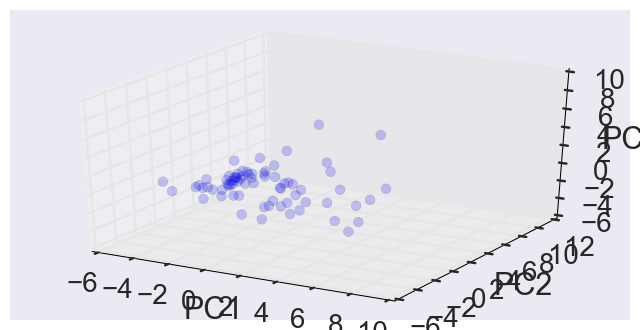

In [130]:
# peida

pc3df = pd.DataFrame(X3, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs = pc3df['PC1'] , ys = pc3df['PC2'], zs=pc3df['PC3'], alpha = 0.2, s = 50)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

In [57]:
PCAdf3 = pd.DataFrame(X3, columns=['PC1','PC2','PC3'])
PCAdf3.head()

PC1       PC2       PC3
0 -2.077225  0.238312  0.387544
1 -1.735436 -1.225661 -1.111291
2  6.702670 -3.292956  1.376816
3 -1.462501  0.288753  0.223229
4 -1.837540 -0.377451 -0.194228

### Part 6: Additional Analysis
Include any other models you'd like to run here. These can include regressions, classifications, or clusters. 

In [102]:
db = DBSCAN(eps =1, min_samples=4).fit(xStand)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(xStand, labels, random_state=43))

Estimated number of clusters: 2
Silhouette Coefficient: -0.238


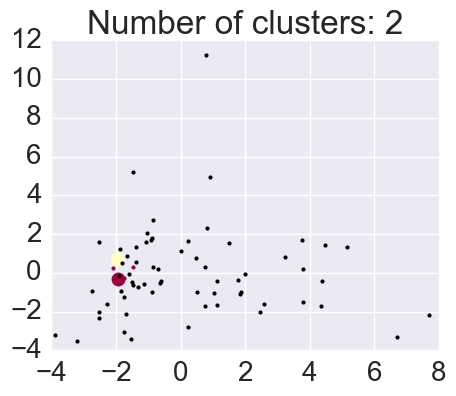

In [118]:
def plot_dbscan(db, X):
    fig = plt.figure(figsize=(5,4))
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
#             Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=3)
        
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=10)

       
    #plt.gca().set_xlim(-2.5,2.5)
    #plt.gca().set_ylim(-2.5,2.5)
    plt.title('Number of clusters: %d' % n_clusters_);
    
plot_dbscan(db, X3)

### Part 7: Write an analysis plan of your findings 

Create a writeup on the interpretation of findings including an executive summary with conclusions and next steps. Put it on your blog, and include the link here.

Which operational features are most correlated with delays?

What should the airport's next steps be?

### Bonus: Copy your Database to AWS 

Make sure to properly document all of the features of your dataset

### Bonus: Create a 3-Dimensional Plot of your new dataset with PCA applied